(tsoverview)=

# Conceptual overview of tree sequence recording

`fwdpy11` 0.2.0 added support for tree sequence recording (`TSR`),
which is a method to both speed up forward-time simulations and to
track the entire genealogical history of the simulation.
The key reference describing `TSR` is {cite}`Kelleher2016-cb`, which in turn relies
heavily on concepts described in {cite}`Kelleher2016-cb`.

The goal of `TSR` is to track a set of tables that contain the trees describing the ancestry of the population.

## Trees and tables

To start out, let us consider the following tree:

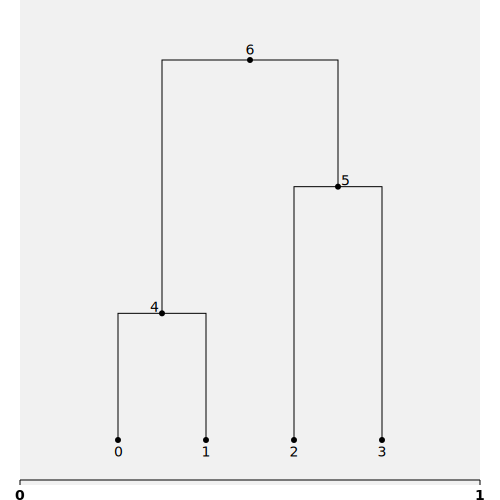

In [1]:
import tskit
from IPython.display import SVG
from myst_nb import glue

tc = tskit.TableCollection(1.)
tc.nodes.set_columns(flags=[1]*4+[0]*3, time=[0]*4+[1,2,3])
tc.edges.add_row(parent=4, child=0, left=0., right=1.)
tc.edges.add_row(parent=4, child=1, left=0., right=1.)
tc.edges.add_row(parent=5, child=2, left=0., right=1.)
tc.edges.add_row(parent=5, child=3, left=0., right=1.)
tc.edges.add_row(parent=6, child=4, left=0., right=1.)
tc.edges.add_row(parent=6, child=5, left=0., right=1.)

ts = tc.tree_sequence()
glue("example_tree", SVG(ts.draw_svg(size=(500, 500))), display=False)

```{glue:figure} example_tree
:name: 'example_tree'

A tree with seven nodes.
```

This tree is the "marginal" history of a genomic segment covering the half-open interval {math}`[0, 1)`.
In other words, all genomic positions in this interval have the same ancestry, and recombination results in different intervals having different trees.

Following {cite}`Kelleher2016-cb`, we can represent the above tree using two tables:

In [2]:
import pandas as pd

nodes = pd.DataFrame({'id': [i for i in range(len(ts.tables.nodes))],
                      'time': ts.tables.nodes.time})
edges = pd.DataFrame({'parent': ts.tables.edges.parent,
                      'child': ts.tables.edges.child,
                      'left': ts.tables.edges.left,
                      'right': ts.tables.edges.right})

First we have the `nodes`:

In [3]:
nodes

,id,time
0,0,0.0
1,1,0.0
2,2,0.0
3,3,0.0
4,4,1.0
5,5,2.0
6,6,3.0


Second, we have the `edges`:

In [4]:
edges

,parent,child,left,right
0,4,0,0.0,1.0
1,4,1,0.0,1.0
2,5,2,0.0,1.0
3,5,3,0.0,1.0
4,6,4,0.0,1.0
5,6,5,0.0,1.0


We learn two things from {numref}`example_tree` and its associated tables:

1. Node tables track the birth times of nodes.  Here, we measure time as increasing from past to the present.
2. Edge tables record the transmissions of genomic intervals from parents to children.  The parent/child fields
   are indexes of the node table.

Edge tables have specific sorting requirements.  The sorting is nested:

1. Decreasing order of parent birth times (as we read the table from top to bottom).
2. For edges with the same parent, child indexes are sorted in increasing order
3. Finally, edges are sorted by increasing left position.

## Relating an evolving population to node and edge tables

Consider the case of a diploid Wright-Fisher population.  There are {math}`N` individuals, and
thus {math}`2N` haploid genomes.  Define a genome as all of the genomic intervals inherited from a
single parent.  Positions along the genome have values from the interval {math}`[0,L)`, and we do not
care if positions take on continuous or discrete values within that interval.

At any time point, we may describe the population as consisting of {math}`2N` nodes with integer labels
{math}`[i,i+2N)`.  Our diploids are then defined as adjacent tuples of nodes,
{math}`D \in [(i,i+1),(i+2,i+3),\ldots,(i+2N-2,i+2N-1)]`.  Node labels thus represent haploid genomes.

To generate the next generation, offspring are generated by recording which intervals they inherit from which parental
nodes.  These intervals are determined by the usual rules of evolving a Wright-Fisher model with selection and
recombination.  We record these transmission events as *edges*, which we may describe as tuples `(left, right, parent,
child)`. In words, such a tuple means "Parental node label `parent` transmitted the genomic interval
{math}`[left,right)` to offspring node label `child`".

The task of a forward simulation is to record new nodes and edges as they arise.  The simulation ends up recording many
transmission events that quickly go extinct.  The simplification algorithm described in the 2018 paper mentioned above
takes this "messy" node and edge table and returns "simplified" node and edge tables.

We can visualize this process using an example implemented with `tskit`. 
We implement a Wright-Fisher model for a diploid population without recombination and without selection:

In [5]:
import tskit
import numpy as np

In [6]:
def wf1(N, ngens):
    tc = tskit.TableCollection(1.0)
    # Add 2N nodes at time = 0.
    # These nodes represent the
    # initial list of parental
    # gametes
    for i in range(2 * N):
        tc.nodes.add_row(time=0, flags=tskit.NODE_IS_SAMPLE)
    next_offspring_index = len(tc.nodes)
    first_parental_index = 0
    for gen in range(1, ngens + 1):
        assert next_offspring_index == len(tc.nodes)
        assert first_parental_index == len(tc.nodes) - 2 * N
        # Pick 2N parents
        parents = np.random.randint(0, N, 2 * N)
        for parent1, parent2 in zip(parents[::2], parents[1::2]):
            # Pick 1 gamete from each parent
            mendel = np.random.random_sample(2)
            g1 = first_parental_index + 2 * parent1 + (mendel[0] < 0.5)
            g2 = first_parental_index + 2 * parent2 + (mendel[1] < 0.5)
            # Add nodes for our offspring's
            # two gametes
            tc.nodes.add_row(time=gen, flags=tskit.NODE_IS_SAMPLE)
            tc.nodes.add_row(time=gen, flags=tskit.NODE_IS_SAMPLE)
            # Add edges reflecting the
            # transmission from parental
            # nodes to offspring nodes
            tc.edges.add_row(left=0.0, right=1.0, parent=g1, child=next_offspring_index)
            tc.edges.add_row(
                left=0.0, right=1.0, parent=g2, child=next_offspring_index + 1
                )
            next_offspring_index += 2
        first_parental_index += 2 * N
    return tc

## Tree sequence simplification

Let's run the simulation for a few generations and look at the resulting tree:

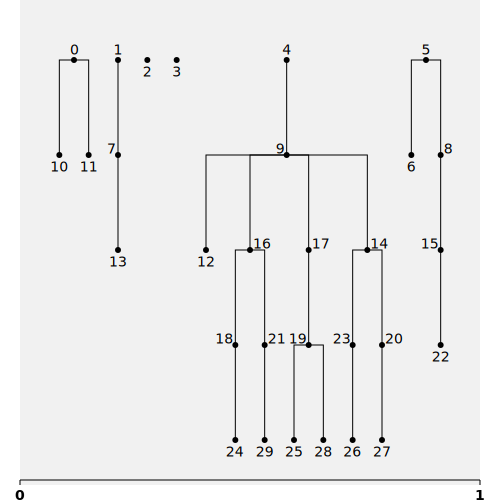

In [7]:
np.random.seed(42)
tc = wf1(3, 4)
# Before we can get a tree sequence from
# the data, we must change direction of
# time from foward to backwards to satisty
# tskit:
t = tc.nodes.time
t -= tc.nodes.time.max()
t *= -1.0
tc.nodes.set_columns(time=t, flags=tc.nodes.flags)
# Sort the tables:
tc.sort()
ts = tc.tree_sequence()
SVG(ts.draw_svg(size=(500,500)))

The resulting tree contains information for extinct lineages as well as redundant node information.  Note
that the three diploids in the last generation are defined by node pairs `(24,25)`, `(26,27)`, and `(28,29)`.

Let's apply the simplification algorithm now.
Simplification returns the minimal history of a specific set of nodes that we may call the "sample nodes".
Here, our sample nodes will be those nodes corresponding to the individuals alive at the end of the simulation.

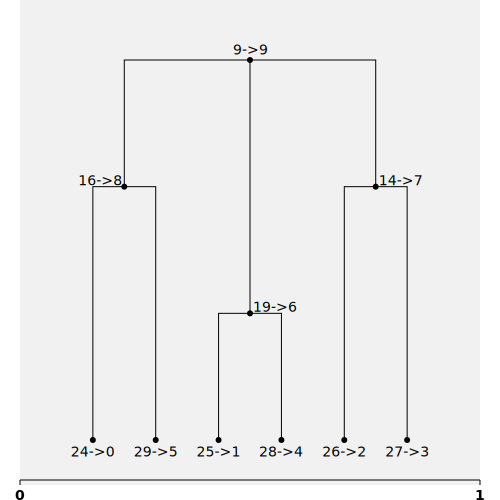

In [8]:
samples = np.where(tc.nodes.time == 0)[0]
node_map = tc.simplify(samples=samples.tolist())
ts = tc.tree_sequence()
tree = ts.first()
imap = {node_map[node]: node for node in range(len(node_map))}
nl = {i: f"{imap[i]}->{i}" for i in tree.nodes()}
SVG(ts.draw_svg(size=(500,500), node_labels=nl))

That's much nicer!  The simplified tree shows now the *input* node ids are remapped to *output* node ids
in such a manner that relative ordering is preserved.

Thus, the most practical view of `TSR` is this: we speed up the simulations by *not* simulating neutral mutations.
We only have to simulate the selected variants and occasionally simplify our messy trees.  The realized speedups are
huge, and I refer you to the 2018 paper for the data on that.  But our simulations are not only faster.  They record
much more information.  The tables of nodes, edges, etc., record the entire history of the simulation with respect to a
set of sample nodes.

:::{note}
An important feature of the simplification algorithm is that we are *not* restricted to only using our "alive" nodes as our sample nodes.
In fact, we can simplify with respect to any set of nodes in the tables.
This feature allows us to keep nodes corresponding to "ancient samples" during a simulation.
We simply mark them as nodes that we want to keep, and the algorithm does the rest.
See {ref}`here <ancient_samples_vignette>` for how to do this in a simulation.
:::